In [26]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

import wfdb

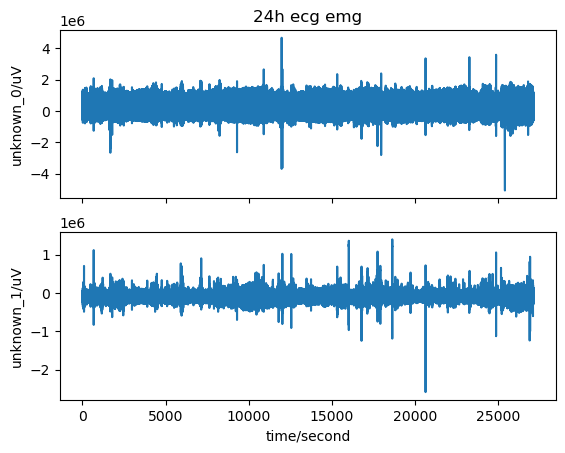

{'record_name': 's0030-04051907', 'n_sig': 2, 'fs': 1000, 'counter_freq': None, 'base_counter': None, 'sig_len': 27116396, 'base_time': datetime.time(8, 42, 42), 'base_date': datetime.date(2004, 5, 19), 'comments': [], 'sig_name': ['unknown_0', 'unknown_1'], 'p_signal': array([[-22000., -16000.],
       [-20000., -16000.],
       [-19000., -16000.],
       ...,
       [-54000., -39000.],
       [-60000., -38000.],
       [-66000., -37000.]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['s0030-04051907.dat', 's0030-04051907.dat'], 'fmt': ['16', '16'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [1.0, 1.0], 'baseline': [0, 0], 'units': ['uV', 'uV'], 'adc_res': [16, 16], 'adc_zero': [0, 0], 'init_value': [-22, -16], 'checksum': [15284, 19109], 'block_size': [0, 0]}


In [32]:
record = wfdb.rdrecord('24h-emgcg/s0030-04051907', channels=[0, 1])
record.p_signal *= 1000  # Convert from uV to mV
wfdb.plot_wfdb(record=record, title='24h ecg emg')
print(record.__dict__)

In [28]:
folder_path = '24h-emgcg/'

record_files = [f for f in os.listdir(folder_path) if f.endswith('.hea')]
records_samples = []

for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]
    record_header = wfdb.rdheader(os.path.join(folder_path, record_name))
    num_samples = record_header.sig_len
    records_samples.append([record_name, num_samples])

# Now records_samples contains a list of [record_name, num_samples] for each record
for record, samples in records_samples:
    print(f"Record '{record}' has {samples} samples.")


Record 's0218-05110112' has 30260496 samples.
Record 's0194-05071409' has 39549486 samples.
Record 's0064-05081806' has 57574788 samples.
Record 's0321-07022204' has 21912 samples.
Record 's0067-05040511' has 49570746 samples.
Record 's0132-04102802' has 46897408 samples.
Record 's0242-06012407' has 37140432 samples.
Record 's0030-04051908' has 55066318 samples.
Record 's0067-05040510' has 8035950 samples.
Record 's0321-07022205' has 27890484 samples.
Record 's0194-05071408' has 43629450 samples.
Record 's0221-06082201' has 16404 samples.
Record 's0218-05110113' has 51666246 samples.
Record 's0221-06082203' has 6888 samples.
Record 's0064-05081805' has 25282776 samples.
Record 's0172-05071906' has 40709484 samples.
Record 's0132-04102801' has 26168545 samples.
Record 's0243-06031609' has 33042288 samples.
Record 's0232-06060108' has 26105460 samples.
Record 's0242-06012405' has 45681954 samples.
Record 's0244-06041304' has 54407868 samples.
Record 's0321-07022206' has 55360422 samples.

In [33]:
# Define the folder path containing the ECG records
folder_path = '24h-emgcg/'

# List all record files in the folder by their .hea extension
record_files = [f for f in os.listdir(folder_path) if f.endswith('.hea')]

for record_file in record_files:
    # Extract the base name of the record (without extension)
    record_name = os.path.splitext(record_file)[0]
    
    # Define the path to the current record
    record_path = os.path.join(folder_path, record_name)
    
    # Read the specified channels (0 and 1) from the record
    record = wfdb.rdrecord(record_path, channels=[0, 1])
    
    # Extract the signals for channels 0 and 1
    signals = record.p_signal
    
    # Define the output file path for the converted signal
    output_file_path = os.path.join(folder_path, f"{record_name}_p_signal.txt")
    
    # Write the signals to the output file
    with open(output_file_path, 'w') as file:
        for signal in signals:
            # Write each signal sample to the file, separated by a tab
            # This results in each line containing: channel_0_value  channel_1_value
            file.write(f"{signal[0]}\t{signal[1]}\n")

print("Conversion completed. The .p_signal files are saved in the '24h-emgcg/' folder.")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/macad/Documents/University/Thesis/ECG Processing/elderly-stroke/24h-emgcg/s0228-06011210.dat'

In [35]:
import wfdb
import os

# Define the folder path containing the ECG records
folder_path = '24h-emgcg/'

# List all .hea files in the folder
record_files = [f for f in os.listdir(folder_path) if f.endswith('.hea')]

# Initialize an array to hold the names of records missing .dat files
records_missing_dat = []

for record_file in record_files:
    # Extract the base name of the record (without extension)
    record_name = os.path.splitext(record_file)[0]
    
    # Check if the corresponding .dat file exists
    if not os.path.exists(os.path.join(folder_path, f"{record_name}.dat")):
        records_missing_dat.append(record_name)
        continue  # Skip to the next record
    
    # Define the path for the output .p_signal file
    output_file_path = os.path.join(folder_path, f"{record_name}_p_signal.txt")
    
    # Check if the .p_signal file already exists
    if os.path.exists(output_file_path):
        continue  # Skip to the next record if .p_signal file exists
    
    # Read the specified channels (0 and 1) from the record
    try:
        record = wfdb.rdrecord(os.path.join(folder_path, record_name), channels=[0, 1])
    except FileNotFoundError:
        # This block catches the case where the .hea file exists without its .dat file,
        # although this should be primarily handled by the earlier .dat check
        records_missing_dat.append(record_name)
        continue
    
    # Extract the signals for channels 0 and 1
    signals = record.p_signal
    
    # Write the signals to the output file
    with open(output_file_path, 'w') as file:
        for signal in signals:
            file.write(f"{signal[0]}\t{signal[1]}\n")

# Output the records that were skipped due to missing .dat files
print("Conversion completed. The following records were skipped due to missing .dat files:")
print(records_missing_dat)


Conversion completed. The following records were skipped due to missing .dat files:
[]
